### Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functions    # my own functions which are used in more notebooks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import tqdm
import math
import kds
import pickle
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
import gensim
print((gensim.__version__))  
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report, accuracy_score,precision_score,recall_score
from re import search
from sklearn.ensemble import RandomForestClassifier
from re import search

4.1.2


## Upload cleaned abstracts

In [3]:
df_all = pd.read_csv("1.Preprocessing_outputs/df_sw_tok_low_punc_lemm_v6.csv").rename(columns = {'doi_x':'doi'}).set_index("doi")

In [4]:
len(df_all)

483636

In [5]:
df_all.head(2)

,Unnamed: 0,Year,Month,abstract,cord_uid,len,abstract_cleaned
doi,,,,,,,
10.1186/1471-2334-1-6,0,2001.0,7.0,OBJECTIVE: This retrospective chart review des...,ug7v899j,1158,retrospective chart review describes epidemiol...
10.1186/rr14,1,2000.0,8.0,Inflammatory diseases of the respiratory tract...,02tnwd4m,718,inflammatory disease respiratory tract commonl...


## Parameters

In [29]:
train_year_of_citations = 2018
test_year_of_citations = 2019   # future year of validation (model is also validated on train year of citations)

# which articles based on year of publication will be selected for training and testing
min_train_year_published = 2017
max_train_year_published = 2018
min_test_year_published = 2019
max_test_year_published = 2019

embeddings_from_year = 2017
embeddings_to_year = 2018

classifier = "lr"  # or "rf"

## Add target flag for dataframe

In [11]:
train_df = functions.add_target_opencitatins_marginal(target_year = train_year_of_citations,df = df_all,target_col_name="target")
test_df = functions.add_target_opencitatins_marginal(target_year = test_year_of_citations, df = df_all,target_col_name = "target")

b'Skipping line 171761: expected 5 fields, saw 8\nSkipping line 208878: expected 5 fields, saw 8\n'


0    7962
1    6456
Name: target, dtype: int64
14418


b'Skipping line 171761: expected 5 fields, saw 8\nSkipping line 208878: expected 5 fields, saw 8\n'


0    9202
1    7445
Name: target, dtype: int64
16647


## Train test split based on year of publication 

In [12]:
train_df = train_df[(df_all['Year']<=max_train_year_published) & (df_all['Year']>= min_train_year_published)] 
print(len(train_df))

test_df = test_df[(df_all['Year']<=max_test_year_published) & (df_all['Year']>= min_test_year_published)] 
print(len(test_df))

2395
1029


# BOW + CF

### Features - BOW Binary input matrix

In [14]:
cvec = CountVectorizer(analyzer = "word", 
                       tokenizer = None, 
                       ngram_range=(1,1), 
                       binary= True,
                       min_df = 2,
                      ) 

matrix_bow_train = cvec.fit_transform(train_df['abstract_cleaned'])
tokens_bow_train = cvec.get_feature_names()

with open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/tokens_bow_'+str(train_year_of_citations)+'.data', 'wb') as filehandle:
    pickle.dump(tokens_bow_train, filehandle)
    
matrix_bow_train_pd = pd.DataFrame.sparse.from_spmatrix(matrix_bow_train, columns = tokens_bow_train)
matrix_bow_train_pd = matrix_bow_train_pd[sorted(matrix_bow_train_pd.columns)]
print(matrix_bow_train.shape)

# for testing we need to have the same features like in training, not new, not less ! 
matrix_bow_test = cvec.fit_transform(test_df['abstract_cleaned'])
tokens_bow_test = cvec.get_feature_names()
matrix_bow_test_pd = pd.DataFrame.sparse.from_spmatrix(matrix_bow_test, columns = tokens_bow_test)
print(len(matrix_bow_test_pd))
not_in_test = np.setdiff1d(tokens_bow_train,tokens_bow_test)
columns_in_both = list(set(tokens_bow_train) & set(tokens_bow_test))
matrix_bow_test_pd_without_new_col = matrix_bow_test_pd[columns_in_both]

for col in tqdm(not_in_test): 
    matrix_bow_test_pd_without_new_col[col] =  np.nan
print(len(matrix_bow_test_pd_without_new_col.columns))

matrix_bow_test_pd = matrix_bow_test_pd_without_new_col.fillna(0)
matrix_bow_test_pd = matrix_bow_test_pd[sorted(matrix_bow_test_pd.columns)]

(2395, 9606)
1029


100%|█████████████████████████████████████████████████████████████████████████████| 3962/3962 [00:04<00:00, 845.60it/s]


9606


In [15]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(matrix_bow_train_pd, train_df.target, test_size=0.2, random_state=1,stratify= train_df["target"])

In [16]:
splitted_train_features = y_test_bow.reset_index().merge(train_df, on="doi",how="left")

#  Classifier

In [18]:
if classifier == "lr":
    cf_bow_splitted_train = LogisticRegression(random_state=0, C=0.2, penalty = "l1",solver = "liblinear").fit(X_train_bow, y_train_bow)
    pickle.dump(cf_bow_splitted_train, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/lreg_bow_'+str(train_year_of_citations)+'.sav', 'wb'))

if classifier == "rf":
    cf_bow_splitted_train = RandomForestClassifier(random_state=0).fit(X_train_bow, y_train_bow)
    pickle.dump(cf_bow_splitted_train, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/rf_bow_'+str(train_year_of_citations)+'.sav', 'wb'))
    
y_pred_bow_splitted_train = cf_bow_splitted_train.predict_proba(X_test_bow)[:,1]
y_pred_bow_whole_train = cf_bow_splitted_train.predict_proba(matrix_bow_train_pd)[:,1]
y_pred_bow_test = cf_bow_splitted_train.predict_proba(matrix_bow_test_pd)[:,1]

### Save outputs for validation

In [19]:
matrix_pred_real = [ 
             ('predictions whole train set', y_pred_bow_whole_train, train_df.target),
             ('predictions splitted train set', y_pred_bow_splitted_train,y_test_bow),
             ('predictions tested new month',y_pred_bow_test,test_df.target),
             ]

results_train = pd.DataFrame(zip(list( y_pred_bow_whole_train),list(train_df.target), list(train_df.Year), list(train_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_splitted_train = pd.DataFrame(zip(list( y_pred_bow_splitted_train),list(y_test_bow), list(splitted_train_features.Year), list(splitted_train_features.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_test = pd.DataFrame(zip(list( y_pred_bow_test),list(test_df.target), list(test_df.Year), list(test_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])

### ROC 

Model : ROC AUC=0.766
No Skill: ROC AUC=0.500


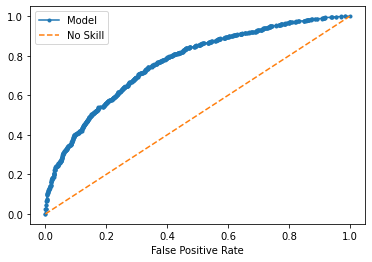

Model : ROC AUC=0.646
No Skill: ROC AUC=0.500


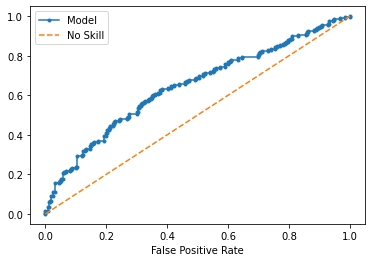

Model : ROC AUC=0.546
No Skill: ROC AUC=0.500


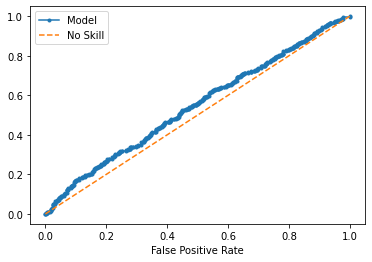

In [20]:
for name, pred, real in matrix_pred_real: 
    functions.roc(real, pred)

### Lift chart

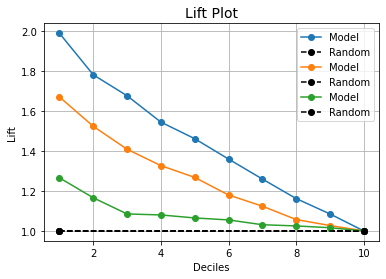

In [21]:
for name, pred, real in matrix_pred_real: 
    kds.metrics.plot_lift(real, pred)

### Auc per publication year 

<BarContainer object of 2 artists>
<BarContainer object of 1 artists>


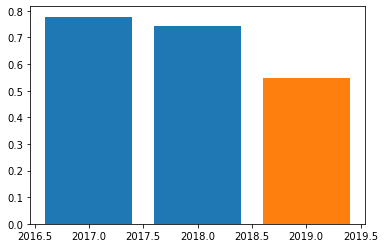

In [22]:
for results in [results_train, results_test]:
    auc_values = []
    number_of_art =[]
    number_of_high =[]
    for year in list(set(results.Year.values)):
        df_f = results[results['Year']==year]   
        if len(pd.DataFrame(df_f.value_counts()))==1:
            auc_values.append(None)    
        if len(pd.DataFrame(df_f.value_counts()))>2:
            auc_values.append(roc_auc_score(df_f.real,df_f.y_pred))    
        number_of_art.append(len(df_f))
        number_of_high.append(len(df_f[df_f['real']==1]))    
    results_final = pd.DataFrame(zip(list(set(results.Year.values)),auc_values,number_of_art,number_of_high),columns=['Year',"AUC","number_of_articles","number_of_high"])
    results_final['%_high'] = results_final['number_of_high']/results_final['number_of_articles']
    print(plt.bar(results_final.Year, results_final.AUC))

# Top x% with highest OpenCitations + x% of lowest citations

- Nevýhoda tohoto přístupu: vždy ty procenta maji v sobě ty předchozí články.

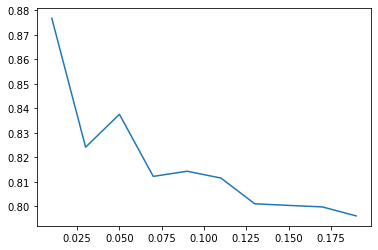

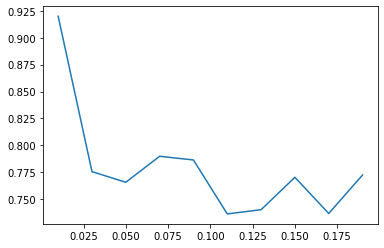

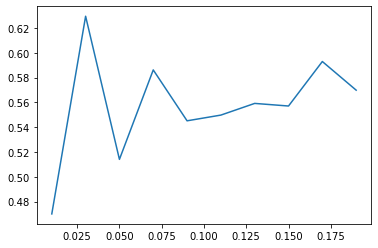

In [23]:
list_df = []
for results in [results_train,results_splitted_train, results_test]:
    auc_list=[]
    perc_list = [0.19,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01] 
    for perc in perc_list:
        auc_list.append(roc_auc_score(functions.x_first_last_val(results,perc).real.values, 
                                      functions.x_first_last_val(results,perc).y_pred.values
                                     )
                       )
    auc_per_perc = pd.DataFrame(zip(auc_list,perc_list),columns=["auc","perc"])
    list_df.append(auc_per_perc)
    plt.plot(auc_per_perc.perc, auc_per_perc.auc)
    plt.show()
    plt.close()

In [25]:
res_list = []
perc_list_1 = [1.0] + perc_list
print(perc_list_1)

for frac in perc_list_1:
    if frac == 1: 
        df_res = functions.resulted_matrics_table(matrix_pred_real,frac_articles=1)

    if frac <1:
        y_real_train = functions.x_first_last_val(results_train,frac).real.values
        probs_train =functions.x_first_last_val(results_train,frac).y_pred.values
        y_real_train_spl = functions.x_first_last_val(results_splitted_train,frac).real.values
        probs_train_spl =functions.x_first_last_val(results_splitted_train,frac).y_pred.values
        y_real_test = functions.x_first_last_val(results_test,frac).real.values
        probs_test =functions.x_first_last_val(results_test,frac).y_pred.values

        matrix_pred_real_2 = [ 
             ('predictions whole train set', probs_train, y_real_train),
             ('predictions tested new month',probs_test,  y_real_test),
              ('predictions splitted train set', probs_train_spl,y_real_train_spl)
             ]
    
        df_res  = functions.resulted_matrics_table(matrix_pred_real_2,frac_articles=frac)
    df_res["perc"] = frac
    res_list.append(df_res)    
    
    
res_all = pd.concat(res_list).pivot(index = "perc",
                          columns='dataset_of_predictions', 
                          values=["AUC","Accuracy","Precision","Recall"]
                                  )
res_all.to_csv('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/res_all_bow_'+str(train_year_of_citations)+'.csv')
res_all

[1.0, 0.19, 0.17, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.03, 0.01]


AUC  \
dataset_of_predictions predictions splitted train set   
perc                                                    
0.01                                         0.840000   
0.03                                         0.785714   
0.05                                         0.739583   
0.07                                         0.774221   
0.09                                         0.749594   
0.11                                         0.743681   
0.13                                         0.742716   
0.15                                         0.723187   
0.17                                         0.748209   
0.19                                         0.755585   
1.00                                         0.645534   

                                                     \
dataset_of_predictions predictions tested new month   
perc                                                  
0.01                                       0.790000   
0.03                                       0.585848   
0.05                                       0.547097   
0.07                                       0.577932   
0.09                                       0.551740   
0.11                                       0.545618   
0.13                                       0.526843   
0.15                                       0.555743   
0.17                                       0.563461   
0.19                                       0.548886   
1.00                                       0.546482   

                                                    \
dataset_of_predictions predictions whole train set   
perc                                                 
0.01                                      0.876736   
0.03                                      0.882137   
0.05                                      0.835694   
0.07                                      0.824972   
0.09                                      0.798290   
0.11                                      0.827003   
0.13                                      0.813009   
0.15                                      0.783510   
0.17                                      0.811562   
0.19                                      0.795380   
1.00                                      0.765750   

                                             Accuracy  \
dataset_of_predictions predictions splitted train set   
perc                                                    
0.01                                         0.900000   
0.03                                         0.785714   
0.05                                         0.708333   
0.07                                         0.735294   
0.09                                         0.709302   
0.11                                         0.688679   
0.13                                         0.701613   
0.15                                         0.694444   
0.17                                         0.691358   
0.19                                         0.686813   
1.00                                         0.634656   

                                                     \
dataset_of_predictions predictions tested new month   
perc                                                  
0.01                                       0.650000   
0.03                                       0.532258   
0.05                                       0.509804   
0.07                                       0.541667   
0.09                                       0.532258   
0.11                                       0.522124   
0.13                                       0.518657   
0.15                                       0.512987   
0.17                                       0.534286   
0.19                                       0.520408   
1.00                                       0.523810   

                                                    \
dataset_of_predictions predictions whole train set   
perc                                         

In [27]:
high_score_art_lr_bow = pd.DataFrame(list(zip(list(y_pred_bow_test), list(test_df.target.values), list(test_df.abstract.values),list(test_df.index),list(test_df.OpenCitations.values),list(test_df.Year.values) )),columns =["score","target","abstract","doi","OpenCitations","Year"])
high_score_art_lr_bow = high_score_art_lr_bow.sort_values("score",ascending=False)
high_score_art_lr_bow.to_csv('3.Classifiers_outputs/train_'+str(test_year)+'/'+"score_art_lr_bow.csv")
high_score_art_lr_bow[:25]

,score,target,abstract,doi,OpenCitations,Year
520,0.871771,1,"BACKGROUND: In 2015, the 68th World Health Ass...",10.1373/clinchem.2018.292391,2.0,2019.0
313,0.825295,0,Introduction: The highly pathogenic coronaviru...,10.1080/17460441.2019.1581171,1.0,2019.0
815,0.820100,1,The enterotoxigenic Escherichia coli (ETEC) ex...,10.1186/s40104-019-0352-7,4.0,2019.0
677,0.814943,0,The increasing appreciation for the crucial ro...,10.1016/j.bmc.2019.03.057,1.0,2019.0
1021,0.808460,1,Metagenomic sequencing has the potential to tr...,10.1038/s41587-018-0006-x,11.0,2019.0
570,0.798240,0,Infections induce complex host responses linke...,10.1016/j.immuni.2019.10.014,1.0,2019.0
46,0.793667,1,Lassa fever virus (LASV) causes acute viral ha...,10.1136/bmjgh-2018-001116,5.0,2019.0
707,0.787240,0,Coronaviruses (CoVs) are widespread among mamm...,10.3390/v11080743,1.0,2019.0
409,0.773076,1,Attachment of viruses to cell-surface receptor...,10.1016/j.coviro.2019.01.004,2.0,2019.0
662,0.769424,0,Cytomegalovirus (CMV) infection has a profound...,10.1007/s00430-019-00610-z,1.0,2019.0


<AxesSubplot:>

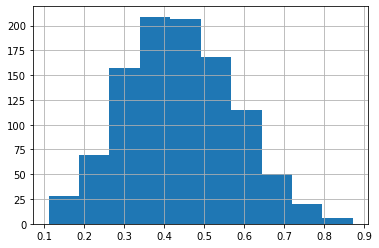

In [28]:
high_score_art_lr_bow["score"].hist()

# EMBEDDINGS

## Agregating w2v Embeddings + LR

- w2v was trained on all articles from kaggle (with or without target - openctitations) - to the target year of publication

In [31]:
model_w2v = gensim.models.Word2Vec.load("2.Train_embeddings_outpus/w2v_published_between_"+str(embeddings_from_year) + " and "+ str(embeddings_to_year)+".model")

In [32]:
train_df["abstract_tokenized"] = functions.tokenized_column(train_df.reset_index()["abstract_cleaned"])
df_X_train_avg = functions.transform_to_document_vector(text_col_tokenized = train_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(train_df.index),agg_func = "avg").fillna(0)
df_X_train_sum = functions.transform_to_document_vector(text_col_tokenized = train_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(train_df.index),agg_func = "sum").fillna(0)

test_df["abstract_tokenized"] = functions.tokenized_column(test_df.reset_index()["abstract_cleaned"])
df_X_test_avg = functions.transform_to_document_vector(text_col_tokenized = test_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(test_df.index),agg_func = "avg").fillna(0)
df_X_test_sum = functions.transform_to_document_vector(text_col_tokenized = test_df.reset_index().abstract_tokenized,model = model_w2v,index_col_list = list(test_df.index),agg_func = "sum").fillna(0)

100%|██████████████████████████████████████████████████████████████████████████████| 1029/1029 [00:10<00:00, 99.40it/s]


## LR

In [33]:
# USE SAME SET FOR COMPARING LIKE IN BOW !!!
X_train_w2v_avg = df_X_train_avg.reset_index().rename({"index":"doi"},axis="columns").merge(y_train_bow.reset_index()[["doi"]],how="right",on="doi").set_index("doi")
X_test_w2v_avg = df_X_train_avg.reset_index().rename({"index":"doi"},axis="columns").merge(y_test_bow.reset_index()[["doi"]],how="right",on="doi").set_index("doi")

X_train_w2v_sum = df_X_train_sum.reset_index().rename({"index":"doi"},axis="columns").merge(y_train_bow.reset_index()[["doi"]],how="right",on="doi").set_index("doi")
X_test_w2v_sum = df_X_train_sum.reset_index().rename({"index":"doi"},axis="columns").merge(y_test_bow.reset_index()[["doi"]],how="right",on="doi").set_index("doi")

y_train_w2v = y_train_bow
y_test_w2v = y_test_bow

In [35]:
if classifier == "lr":
    cf_w2v_splitted_train_avg = LogisticRegression(random_state=0, C=0.2, penalty = "l1",solver = "liblinear").fit(X_train_w2v_avg, y_train_w2v)
    pickle.dump(cf_w2v_splitted_train_avg, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'lreg_w2v_avg_'+str(train_year_of_citations)+'.sav', 'wb'))
    
    cf_w2v_splitted_train_sum = LogisticRegression(random_state=0, C=0.2, penalty = "l1",solver = "liblinear").fit(X_train_w2v_sum, y_train_w2v)
    pickle.dump(cf_w2v_splitted_train_sum, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'lreg_w2v_sum_'+str(train_year_of_citations)+'.sav', 'wb'))
    
if classifier == "rf":
    cf_w2v_splitted_train_avg = RandomForestClassifier(random_state=0).fit(X_train_w2v_avg, y_train_w2v)
    pickle.dump(cf_w2v_splitted_train_avg, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'rf_w2v_avg_'+str(train_year_of_citations)+'.sav', 'wb'))
    cf_w2v_splitted_train_sum = RandomForestClassifier(random_state=0).fit(X_train_w2v_sum, y_train_w2v)
    pickle.dump(cf_w2v_splitted_train_sum, open('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'rf_w2v_sum_'+str(train_year_of_citations)+'.sav', 'wb'))
    
y_pred_w2v_splitted_train_avg = cf_w2v_splitted_train_avg.predict_proba(X_test_w2v_avg)[:,1]
y_pred_w2v_whole_train_avg = cf_w2v_splitted_train_avg.predict_proba(df_X_train_avg)[:,1]
y_pred_w2v_test_avg = cf_w2v_splitted_train_avg.predict_proba(df_X_test_avg)[:,1]

y_pred_w2v_splitted_train_sum = cf_w2v_splitted_train_sum.predict_proba(X_test_w2v_sum)[:,1]
y_pred_w2v_whole_train_sum = cf_w2v_splitted_train_sum.predict_proba(df_X_train_sum)[:,1]
y_pred_w2v_test_sum = cf_w2v_splitted_train_sum.predict_proba(df_X_test_sum)[:,1]

In [36]:
splitted_train_features = y_test_w2v.reset_index().merge(train_df, on="doi",how="left")

In [37]:
results_train_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_whole_train_avg),list(train_df.target), list(train_df.Year), list(train_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_splitted_train_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_splitted_train_avg),list(y_test_w2v), list(splitted_train_features.Year), list(splitted_train_features.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_test_w2v_avg = pd.DataFrame(zip(list( y_pred_w2v_test_avg),list(test_df.target), list(test_df.Year), list(test_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])

results_train_w2v_sum = pd.DataFrame(zip(list( y_pred_w2v_whole_train_sum),list(train_df.target), list(train_df.Year), list(train_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_splitted_train_w2v_sum = pd.DataFrame(zip(list( y_pred_w2v_splitted_train_sum),list(y_test_w2v), list(splitted_train_features.Year), list(splitted_train_features.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])
results_test_w2v_sum = pd.DataFrame(zip(list(y_pred_w2v_test_sum),list(test_df.target), list(test_df.Year), list(test_df.OpenCitations)),columns=["y_pred","real","Year","OpenCitations"])

matrix_pred_real_w2v = [ 
             ('predictions whole train set', y_pred_w2v_whole_train_avg, train_df.target),
             ('predictions splitted train set', y_pred_w2v_splitted_train_avg,y_test_w2v),
             ('predictions tested new month',y_pred_w2v_test_avg,test_df.target),
           #  ('predictions whole train set', y_pred_w2v_whole_train_sum, train_df.target),
           #  ('predictions splitted train set', y_pred_w2v_splitted_train_sum,y_test_w2v),
          #   ('predictions tested new month',y_pred_w2v_test_sum,test_df.target),
             ]

Model : ROC AUC=0.591
No Skill: ROC AUC=0.500


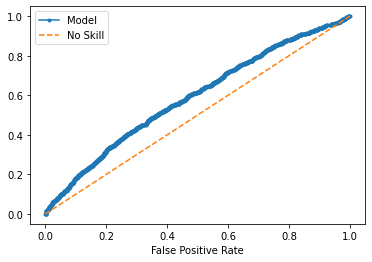

Model : ROC AUC=0.607
No Skill: ROC AUC=0.500


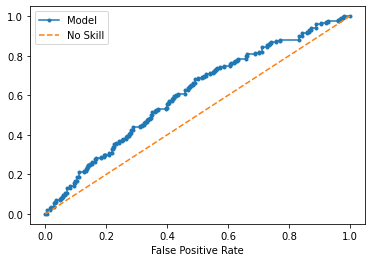

Model : ROC AUC=0.577
No Skill: ROC AUC=0.500


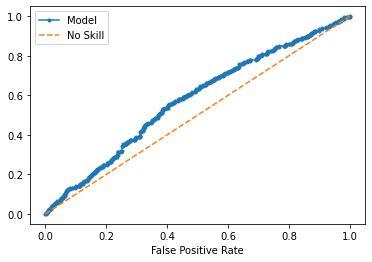

In [38]:
for name, pred, real in matrix_pred_real_w2v: 
    functions.roc(real, pred)

### Lift

predictions whole train set
predictions splitted train set
predictions tested new month


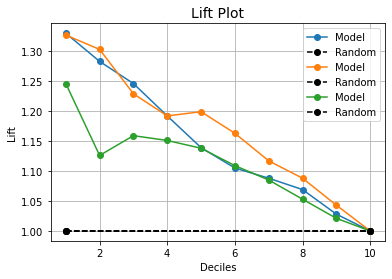

In [39]:
for name, pred, real in matrix_pred_real_w2v: 
    print(name)
    kds.metrics.plot_lift(real, pred)

### AUC PER YEAR

done
<BarContainer object of 2 artists>
done
<BarContainer object of 1 artists>


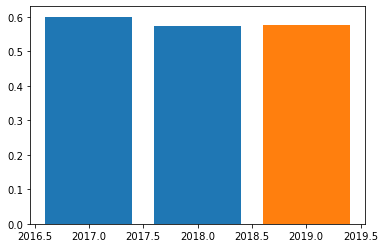

In [40]:
for results in [results_train_w2v_avg, results_test_w2v_avg]:
    print("done")
    auc_values = []
    number_of_art =[]
    number_of_high =[]
    for year in list(set(results.Year.values)):
        df_f = results[results['Year']==year]   
        if len(pd.DataFrame(df_f.value_counts()))==1:
            auc_values.append(None)    
        if len(pd.DataFrame(df_f.value_counts()))>2:
            auc_values.append(roc_auc_score(df_f.real,df_f.y_pred))    
        number_of_art.append(len(df_f))
        number_of_high.append(len(df_f[df_f['real']==1]))    
    results_final = pd.DataFrame(zip(list(set(results.Year.values)),auc_values,number_of_art,number_of_high),columns=['Year',"AUC","number_of_articles","number_of_high"])
    results_final['%_high'] = results_final['number_of_high']/results_final['number_of_articles']
    print(plt.bar(results_final.Year, results_final.AUC))

done
<BarContainer object of 2 artists>
done
<BarContainer object of 1 artists>


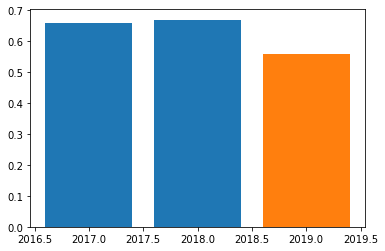

In [41]:
for results in [results_train_w2v_sum, results_test_w2v_sum]:
    print("done")
    auc_values = []
    number_of_art =[]
    number_of_high =[]
    for year in list(set(results.Year.values)):
        df_f = results[results['Year']==year]   
        if len(pd.DataFrame(df_f.value_counts()))==1:
            auc_values.append(None)    
        if len(pd.DataFrame(df_f.value_counts()))>2:
            auc_values.append(roc_auc_score(df_f.real,df_f.y_pred))    
        number_of_art.append(len(df_f))
        number_of_high.append(len(df_f[df_f['real']==1]))    
    results_final = pd.DataFrame(zip(list(set(results.Year.values)),auc_values,number_of_art,number_of_high),columns=['Year',"AUC","number_of_articles","number_of_high"])
    results_final['%_high'] = results_final['number_of_high']/results_final['number_of_articles']
    print(plt.bar(results_final.Year, results_final.AUC))

### Top X% with highest OpenCitations + X% of lowest citations

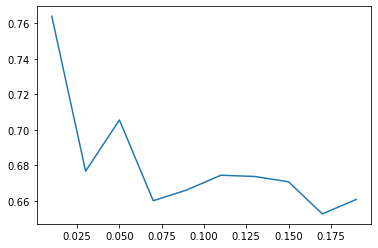

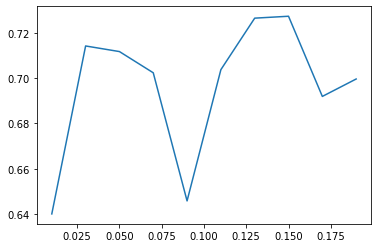

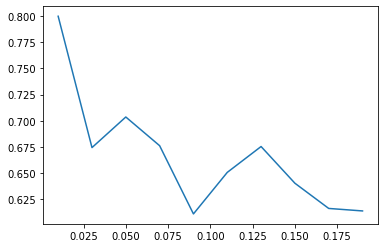

In [42]:
list_df_avg = []
for results in [results_train_w2v_avg,results_splitted_train_w2v_avg, results_test_w2v_avg]:
    auc_list=[]
    
    perc_list = [0.19,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]     
    for perc in perc_list:
        auc_list.append(roc_auc_score(functions.x_first_last_val(results,perc).real.values, functions.x_first_last_val(results,perc).y_pred.values) )
    auc_per_perc = pd.DataFrame(zip(auc_list,perc_list),columns=["auc","perc"])
    list_df_avg.append(auc_per_perc)
    plt.plot(auc_per_perc.perc, auc_per_perc.auc)
    plt.show()
    plt.close()

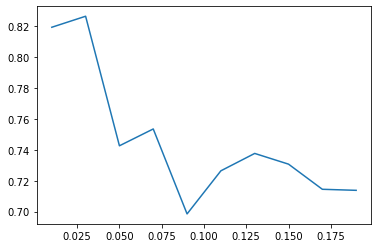

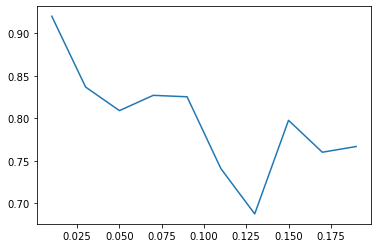

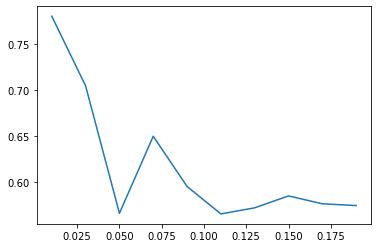

In [43]:
list_df_sum = []
for results in [results_train_w2v_sum,results_splitted_train_w2v_sum, results_test_w2v_sum]:
  #  print("ROC of first "+str(frac_to_visualize*100) + " perc articles with highest citations")
  #  print(functions.roc(y_test = functions.x_first_last_val(results,frac_to_visualize).real.values, probs =functions.x_first_last_val(results,frac_to_visualize).y_pred.values))   
    auc_list=[]
    perc_list = [0.19,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01] 
    for perc in perc_list:
        auc_list.append(   roc_auc_score(functions.x_first_last_val(results,perc).real.values, functions.x_first_last_val(results,perc).y_pred.values) )
    auc_per_perc = pd.DataFrame(zip(auc_list,perc_list),columns=["auc","perc"])
    list_df_sum.append(auc_per_perc)
    plt.plot(auc_per_perc.perc, auc_per_perc.auc)
    plt.show()
    plt.close()

In [45]:
res_list = []
perc_list_1 = [1.0] + perc_list
print(perc_list_1)

for frac in perc_list_1:
    if frac == 1: 
        df_res = functions.resulted_matrics_table(matrix_pred_real_w2v,frac_articles=1)

    if frac <1:
        y_real_train = functions.x_first_last_val(results_train_w2v_avg,frac).real.values
        probs_train =functions.x_first_last_val(results_train_w2v_avg,frac).y_pred.values
        y_real_train_spl = functions.x_first_last_val(results_splitted_train_w2v_avg,frac).real.values
        probs_train_spl =functions.x_first_last_val(results_splitted_train_w2v_avg,frac).y_pred.values
        y_real_test = functions.x_first_last_val(results_test_w2v_avg,frac).real.values
        probs_test =functions.x_first_last_val(results_test_w2v_avg,frac).y_pred.values

        matrix_pred_real_2 = [ 
             ('predictions whole train set', probs_train, y_real_train),
             ('predictions tested new month',probs_test,  y_real_test),
              ('predictions splitted train set', probs_train_spl,y_real_train_spl)
             ]
    
        df_res  = functions.resulted_matrics_table(matrix_pred_real_2,frac_articles=frac)
    df_res["perc"] = frac
    res_list.append(df_res)    
    
    
res_all = pd.concat(res_list).pivot(index = "perc",
                          columns='dataset_of_predictions', 
                          values=["AUC","Accuracy","Precision","Recall"]
                                  )
res_all.to_csv('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/res_all_w2v_avg_'+str(train_year_of_citations)+'.csv')
res_all

[1.0, 0.19, 0.17, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.03, 0.01]


AUC  \
dataset_of_predictions predictions splitted train set   
perc                                                    
0.01                                         0.800000   
0.03                                         0.637755   
0.05                                         0.630208   
0.07                                         0.788927   
0.09                                         0.703083   
0.11                                         0.697757   
0.13                                         0.727627   
0.15                                         0.697338   
0.17                                         0.709191   
0.19                                         0.699312   
1.00                                         0.607161   

                                                     \
dataset_of_predictions predictions tested new month   
perc                                                  
0.01                                       0.830000   
0.03                                       0.625390   
0.05                                       0.611303   
0.07                                       0.647184   
0.09                                       0.594866   
0.11                                       0.619469   
0.13                                       0.604366   
0.15                                       0.630840   
0.17                                       0.668735   
0.19                                       0.664046   
1.00                                       0.577355   

                                                    \
dataset_of_predictions predictions whole train set   
perc                                                 
0.01                                      0.659722   
0.03                                      0.695216   
0.05                                      0.735625   
0.07                                      0.684382   
0.09                                      0.686578   
0.11                                      0.662450   
0.13                                      0.650086   
0.15                                      0.676205   
0.17                                      0.651226   
0.19                                      0.651974   
1.00                                      0.591055   

                                             Accuracy  \
dataset_of_predictions predictions splitted train set   
perc                                                    
0.01                                         0.500000   
0.03                                         0.500000   
0.05                                         0.500000   
0.07                                         0.514706   
0.09                                         0.500000   
0.11                                         0.518868   
0.13                                         0.516129   
0.15                                         0.520833   
0.17                                         0.518519   
0.19                                         0.505495   
1.00                                         0.576200   

                                                     \
dataset_of_predictions predictions tested new month   
perc                                                  
0.01                                       0.550000   
0.03                                       0.548387   
0.05                                       0.519608   
0.07                                       0.527778   
0.09                                       0.510753   
0.11                                       0.504425   
0.13                                       0.518657   
0.15                                       0.512987   
0.17                                       0.511429   
0.19                                       0.510204   
1.00                                       0.520894   

                                                    \
dataset_of_predictions predictions whole train set   
perc                                         

### Abstracts with highest score

In [48]:
high_score_art_lr_w2v_avg = pd.DataFrame(list(zip(list(y_pred_w2v_test_avg), list(test_df.target.values), list(test_df.abstract.values),list(test_df.index),list(test_df.OpenCitations.values),list(test_df.Year.values) )),columns =["score","target","abstract","doi","OpenCitations","Year"])
high_score_art_lr_w2v_avg = high_score_art_lr_w2v_avg.sort_values("score",ascending=False)
high_score_art_lr_w2v_avg[:25]

,score,target,abstract,doi,OpenCitations,Year
630,0.524203,0,Type I and type III interferons are important ...,10.1093/intimm/dxz034,1.0,2019.0
1027,0.523583,1,Autophagy is an essential process that maintai...,10.3390/cells8020138,6.0,2019.0
514,0.520046,1,Interferons (IFNs) play crucial roles in host ...,10.3389/fmicb.2019.01097,6.0,2019.0
547,0.520043,0,Antibodies play a crucial role in host defense...,10.3390/vaccines7030103,1.0,2019.0
492,0.517689,1,How host cells recognize many kinds of RNA and...,10.1111/1348-0421.12669,2.0,2019.0
761,0.517680,1,Macroautophagy (herein referred to as autophag...,10.1016/j.cell.2019.05.026,24.0,2019.0
670,0.510823,1,Interferon (IFN)-mediated antiviral responses ...,10.1038/s41564-019-0421-x,9.0,2019.0
798,0.509640,1,Long noncoding RNAs (lncRNAs) represent a key ...,10.1002/rmv.2046,3.0,2019.0
396,0.508902,0,As part of their innate immune response agains...,10.3390/ncrna5010029,1.0,2019.0
183,0.508889,0,Tripartite motif containing-21 (TRIM21) is a c...,10.3389/fimmu.2019.02049,1.0,2019.0


In [52]:
high_score_art_lr_w2v_sum = pd.DataFrame(list(zip(list(y_pred_w2v_test_sum), list(test_df.target.values), list(test_df.abstract.values),list(test_df.index),list(test_df.OpenCitations.values),list(test_df.Year.values) )),columns =["score","target","abstract","doi","OpenCitations","Year"])
high_score_art_lr_w2v_sum = high_score_art_lr_w2v_sum.sort_values("score",ascending=False)

high_score_art_lr_w2v_avg.to_csv('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'score_art_lr_w2v_avg.csv')
high_score_art_lr_w2v_sum.to_csv('3.Classifiers_outputs/train_'+str(train_year_of_citations)+'/'+'score_art_lr_w2v_sum.csv')

high_score_art_lr_w2v_sum[:25]

,score,target,abstract,doi,OpenCitations,Year
816,0.826192,1,Background: Middle East respiratory syndrome c...,10.1089/vbz.2017.2191,7.0,2019.0
748,0.823741,1,"During pregnancy, the maternal immune response...",10.3389/fimmu.2019.00727,2.0,2019.0
981,0.817436,1,BACKGROUND: Differentiating bacterial from vir...,10.1186/s12890-019-0835-5,3.0,2019.0
325,0.799397,0,"West Nile Virus (WNV), an emerging and re-emer...",10.1371/journal.ppat.1007899,1.0,2019.0
261,0.788019,1,Antibacterial resistance is a great concern an...,10.1038/s41579-019-0288-0,2.0,2019.0
474,0.769998,0,OBJECTIVES: To date no definitive cut-off valu...,10.1016/j.jinf.2019.02.009,1.0,2019.0
145,0.764710,1,"Innate immune interferons (IFNs), particularly...",10.3389/fimmu.2019.01431,3.0,2019.0
913,0.762245,1,BACKGROUND: Microglia are resident macrophages...,10.1186/s12974-019-1397-4,5.0,2019.0
133,0.759834,0,Many emerging arboviruses are not transmitted ...,10.1093/ve/vez010,1.0,2019.0
339,0.753806,1,Type I Interferons (IFNs) are hallmark cytokin...,10.3389/fimmu.2019.00778,2.0,2019.0


<AxesSubplot:>

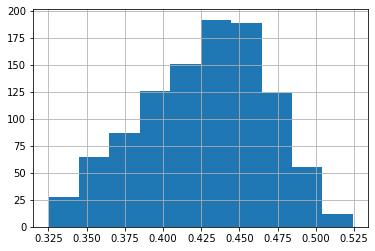

In [50]:
high_score_art_lr_w2v_avg["score"].hist()

<AxesSubplot:>

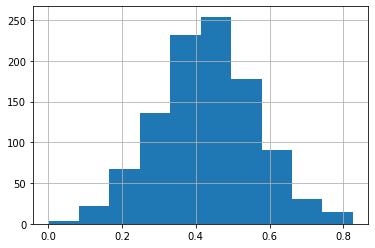

In [51]:
high_score_art_lr_w2v_sum["score"].hist()